In [11]:
import pandas as pd
import networkx as nx
import numpy as np

# Read in the CSV files

# 55% SAR count
#accounts_df = pd.read_csv("../datasets/60K_60_sar_count/account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/60K_60_sar_count/transactions.csv")

# 10% SAR count
#accounts_df = pd.read_csv("../datasets/60K_10_sar_count/account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/60K_10_sar_count/transactions.csv")

# 5% SAR count
accounts_df = pd.read_csv("../datasets/60K_05_sar_count/account_attributes.csv")
transactions_df = pd.read_csv("../datasets/60K_05_sar_count/transactions.csv")

# 1% SAR count
#accounts_df = pd.read_csv("../datasets/60K_01_sar_count/account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/60K_01_sar_count/transactions.csv")


accounts_df = pd.read_csv("../datasets/64K_5_v2_s1/account_attributes.csv")
transactions_df = pd.read_csv("../datasets/64K_5_v2_s1/transactions.csv")

nodes_df = accounts_df
edges_df = transactions_df

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.transforms import NormalizeFeatures

x_np = nodes_df.to_numpy()
x = x_np[:,0:-2]
print(x.shape, x_np.shape)

from torch.utils.data import random_split
# Define your graph
x = torch.nn.functional.normalize(torch.tensor(x),dim=0).to(torch.float32)  # (n x features)
edge_index =  torch.stack([torch.tensor(edges_df.orig_acct.to_numpy()),torch.tensor(edges_df.bene_acct.to_numpy())],dim=-1).T  # Define your edge index
#edge_attr = torch.nn.functional.normalize(torch.tensor(np.array(edges_df[['amount','oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest','isFlaggedFraud','isUnauthorizedOverdraft','action_CASH_IN','action_CASH_OUT','action_DEBIT','action_PAYMENT','action_TRANSFER']].values,dtype='float32')),dim=0) # edge features
edge_weight = torch.nn.functional.normalize(torch.tensor(edges_df.base_amt.to_numpy()),dim=0).long()
y =  torch.tensor(nodes_df.node_isSar.to_numpy().astype(int),dtype=torch.long) # target values

# Bitflip the tensor
#y = y ^ torch.tensor([1], dtype=torch.uint8).expand_as(y)


train_size = int(0.35 * len(y))  # 60% of the dataset for training
val_size = int(0.15 * len(y))    # 20% of the dataset for validation
test_size = len(y) - train_size - val_size  # Remaining 20% for testing

torch.manual_seed(0)
train_dataset, val_dataset, test_dataset = random_split(y, [train_size, val_size, test_size])

# Create masks for train, validation, and test sets
train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)

train_mask[train_dataset.indices] = True
val_mask[val_dataset.indices] = True
test_mask[test_dataset.indices] = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


from torch_geometric.data import Data
# Load your data into PyTorch Geometric's Data class
#data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
#data = Data(x=x, edge_index=edge_index, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data.to(device)



2.0.1+cu118
(64145, 24) (64145, 26)
cuda:0


Data(x=[64145, 24], edge_index=[2, 1429458], y=[64145], edge_weight=[1429458], train_mask=[64145], val_mask=[64145], test_mask=[64145])

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb


In [19]:



trainX = data.x[data.train_mask + data.val_mask].detach().cpu().numpy()
trainY = data.y[data.train_mask + data.val_mask].detach().cpu().numpy()

testX = data.x[data.test_mask].detach().cpu().numpy()
testY = data.y[data.test_mask].detach().cpu().numpy()

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

xgb_model.fit(trainX, trainY)

best_model = xgb_model

In [4]:
params = {
    #"colsample_bytree": [0.3,0.4,0.5,0.6,0.7],
    #"gamma": [0,0.1,0.2,0.3,0.4,0.5],
    #"learning_rate": [0.001,0.005,0.01,0.05,0.1,0.5], # default 0.1 
    "max_depth": [10, 30, 50, 70, 90, None], 
    "n_estimators": [20, 50, 100], # default 100
    "subsample": [0.4,0.45,0.5,0.55,0.6]
}
params = {
"gamma": [0,0.2,0.4,0.6],
 'max_depth': [10, 30, 50, 70, 90, None],
 'n_estimators': [20, 50, 100]}

params

{'gamma': [0, 0.2, 0.4, 0.6],
 'max_depth': [10, 30, 50, 70, 90, None],
 'n_estimators': [20, 50, 100]}

In [40]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, cv=5)
grid_search.fit(trainX, trainY)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\anaconda\envs\anaconda\envs\GDL2\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Julien\AppData\Local\Temp\ipykernel_5544\4091364425.py", line 2, in <module>
    grid_search.fit(trainX, trainY)
  File "d:\anaconda\envs\anaconda\envs\GDL2\lib\site-packages\sklearn\model_selection\_search.py", line 874, in fit
  File "d:\anaconda\envs\anaconda\envs\GDL2\lib\site-packages\sklearn\model_selection\_search.py", line 1388, in _run_search
    }
  File "d:\anaconda\envs\anaconda\envs\GDL2\lib\site-packages\sklearn\model_selection\_search.py", line 821, in evaluate_candidates
    return_times=True,
  File "d:\anaconda\envs\anaconda\envs\GDL2\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    for delayed_func, args, kwargs in iterable
  File "d:\anaconda\envs\anaconda\envs\GDL2\lib\site-packages\joblib\parallel.py", line 1088, in __ca

In [5]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

NameError: name 'grid_search' is not defined

In [6]:
best_params


NameError: name 'best_params' is not defined

In [191]:
import joblib
joblib.dump(best_model, "../datasets/256K_5/random_forest_60k_ .joblib")

['../datasets/256K_5/random_forest_60k_5.joblib']

In [102]:

#best_model = joblib.load("../datasets/256K_5/random_forest_256k.joblib")


In [36]:
#y_pred = np.round(best_model.predict_proba(testX))
y_pred = np.round(best_model.predict_proba(testX)).astype(np.int)[:,1]
#y_pred = 
y_pred


C:\Users\Julien\AppData\Local\Temp\ipykernel_14444\661346920.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.round(best_model.predict_proba(testX)).astype(np.int)[:,1]


array([0, 0, 0, ..., 0, 0, 0])

Precision: 0.99
Recall: 0.87
F1-score: 0.93


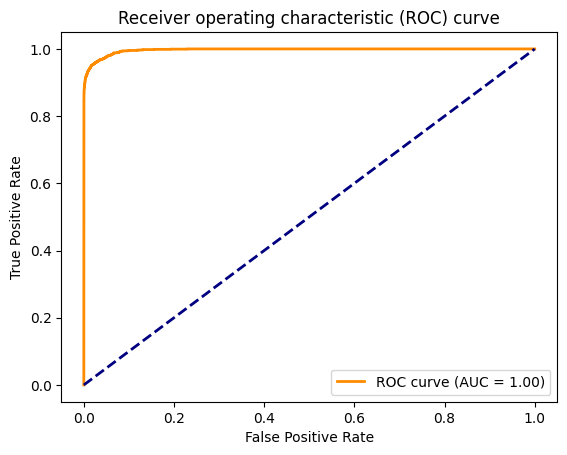

In [38]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
y_true = testY
#print(np.sum(test_pred))
#print(np.sum(y_true)/len(y_true))


# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, (y_pred), average='binary')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

y_pred2 = (best_model.predict_proba(testX))[:,1]
# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred2)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [9]:
clf = best_model
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
import pandas as pd

forest_importances = pd.Series(importances, index=nodes_df.columns[:-2])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

AttributeError: 'XGBRegressor' object has no attribute 'estimators_'

<BarContainer object of 24 artists>

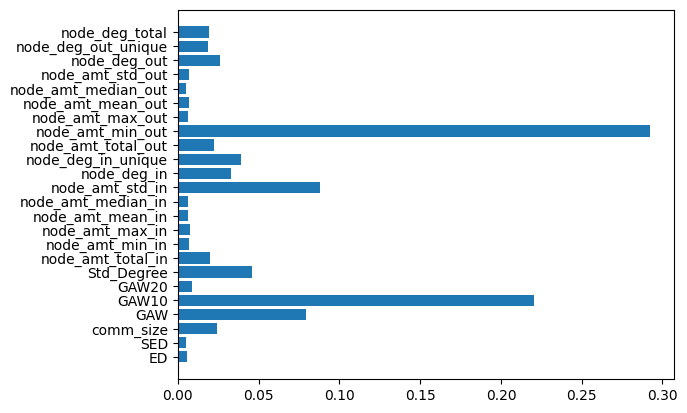

In [10]:
plt.barh(nodes_df.columns[:-2],  clf.feature_importances_)

In [399]:
nodes_df.columns[:]

Index(['GAW', 'GAW10', 'GAW20', 'Std_Degree', 'node_amt_total_in',
       'node_amt_min_in', 'node_amt_max_in', 'node_amt_mean_in',
       'node_amt_median_in', 'node_amt_std_in', 'node_deg_in',
       'node_deg_in_unique', 'node_amt_total_out', 'node_amt_min_out',
       'node_amt_max_out', 'node_amt_mean_out', 'node_amt_median_out',
       'node_amt_std_out', 'node_deg_out', 'node_deg_out_unique',
       'node_deg_total', 'id', 'node_isSar'],
      dtype='object')

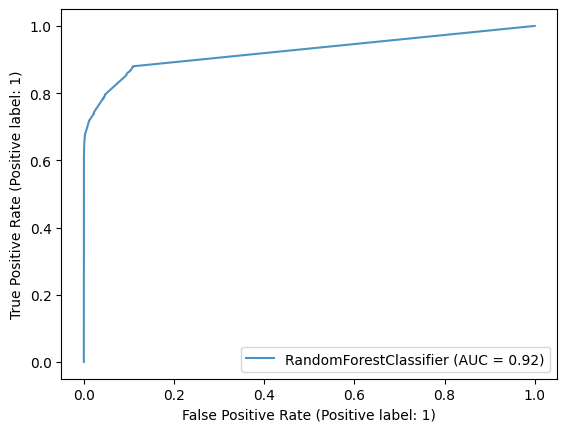

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(trainX, trainY)
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, testX, testY, ax=ax, alpha=0.8)

plt.show()

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_test = rfc.predict(testX)
accuracy_score(testY, y_pred_test)
confusion_matrix(testY, y_pred_test)
print(classification_report(testY, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     28478
           1       0.93      0.68      0.78      1630

    accuracy                           0.98     30108
   macro avg       0.95      0.84      0.89     30108
weighted avg       0.98      0.98      0.98     30108

